Import Libraries

In [45]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os

Define Configuration

In [40]:
# Configuration
train_dir = r"C:\Users\Welcome\ai\archive (1)\dataset\Train"
test_dir = r"C:\Users\Welcome\ai\archive (1)\dataset\Test"
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 1e-5  # Reduced learning rate for fine-tuning

Data Preprocessing & Augmentation

In [41]:
# Clear TensorFlow session
tf.keras.backend.clear_session()

# 🛠 Stronger Data Augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.5, 1.5],
    fill_mode='nearest',
    validation_split=0.2  # Split training data for validation
)

test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)


Create Data Generators

In [42]:
# Data Generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 16840 images belonging to 14 classes.
Found 4204 images belonging to 14 classes.
Found 6738 images belonging to 14 classes.


Create & Fine-Tune ResNet50 Model

In [43]:
def create_resnet_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), num_classes=NUM_CLASSES):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    for layer in base_model.layers[-20:]:  # Unfreeze last 20 layers for fine-tuning
        layer.trainable = True

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=LEARNING_RATE, decay_steps=len(train_generator), decay_rate=0.96, staircase=True
    )
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', 
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    return model


Train the Model

In [ ]:
model = create_resnet_model()
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)


Evaluate Model on Test Set

In [44]:
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


211/211 [==============================] - 24s 108ms/step - loss: 1.1518 - accuracy: 0.9859 - precision: 0.9872 - recall: 0.9846
Test Loss: 1.151766300201416, Test Accuracy: 0.98590087890625


In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os

# Configuration
train_dir = r"C:\Users\Welcome\ai\archive (1)\dataset\Train"
test_dir = r"C:\Users\Welcome\ai\archive (1)\dataset\Test"
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 1e-5  # Reduced learning rate for fine-tuning

# Clear TensorFlow session
tf.keras.backend.clear_session()

# 🛠 Stronger Data Augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.5, 1.5],
    fill_mode='nearest',
    validation_split=0.2  # Split training data for validation
)

test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)

# Data Generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Determine number of classes
NUM_CLASSES = len(train_generator.class_indices)
print("Number of classes:", NUM_CLASSES)
print("Class indices:", train_generator.class_indices)

# 🛠 Learning Rate Schedule
def create_lr_schedule(initial_lr, decay_steps):
    return tf.keras.optimizers.schedules.ExponentialDecay(
        initial_lr, decay_steps, decay_rate=0.96, staircase=True
    )

# 🏗 **ResNet50 Model with Regularization & Fine-Tuning**
def create_resnet_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), num_classes=NUM_CLASSES):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Fine-tuning: Unfreeze only the last 10 layers
    for layer in base_model.layers[-10:]:
        layer.trainable = True
    
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.5),  # Increased dropout
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    # Custom learning rate and optimizer
    lr_schedule = create_lr_schedule(LEARNING_RATE, decay_steps=len(train_generator))
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    
    model.compile(
        optimizer=optimizer, 
        loss='categorical_crossentropy', 
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )
    return model

# 🏗 Callbacks (Early Stopping & Checkpoints)
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=3,  # Reduced patience
    restore_best_weights=True
)

model_checkpoint = callbacks.ModelCheckpoint(
    'best_freshness_model.keras', 
    monitor='val_accuracy', 
    save_best_only=True
)

# Train Model
model = create_resnet_model()
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)


Found 16840 images belonging to 14 classes.
Found 4204 images belonging to 14 classes.
Found 6738 images belonging to 14 classes.
Number of classes: 14
Class indices: {'freshapples': 0, 'freshbanana': 1, 'freshcucumber': 2, 'freshokra': 3, 'freshoranges': 4, 'freshpotato': 5, 'freshtomato': 6, 'rottenapples': 7, 'rottenbanana': 8, 'rottencucumber': 9, 'rottenokra': 10, 'rottenoranges': 11, 'rottenpotato': 12, 'rottentomato': 13}
Epoch 1/20
527/527 [==============================] - 341s 624ms/step - loss: 2.9377 - accuracy: 0.4767 - precision: 0.7430 - recall: 0.3293 - val_loss: 1.7167 - val_accuracy: 0.8230 - val_precision: 0.9148 - val_recall: 0.7329
Epoch 2/20
527/527 [==============================] - 293s 556ms/step - loss: 1.7258 - accuracy: 0.8241 - precision: 0.9001 - recall: 0.7565 - val_loss: 1.6319 - val_accuracy: 0.8290 - val_precision: 0.8651 - val_recall: 0.7961
Epoch 3/20
527/527 [==============================] - 289s 548ms/step - loss: 1.4961 - accuracy: 0.8969 - preci

KeyboardInterrupt: 

In [14]:
# Evaluate on test set
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# # 📈 Plot Training History
# plt.figure(figsize=(12, 4))

# plt.subplot(1, 2, 1)
# plt.plot(history.history['accuracy'], label='Train Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.title('Model Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(history.history['loss'], label='Train Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Model Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()

# plt.tight_layout()
# plt.show()


211/211 [==============================] - 22s 104ms/step - loss: 1.1518 - accuracy: 0.9859 - precision: 0.9872 - recall: 0.9846
Test Loss: 1.151766300201416, Test Accuracy: 0.98590087890625


In [15]:

# ✅ Save Final Model
model.save("final_freshness_resnet_model.keras")

In [16]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image

# Load the trained model
model = tf.keras.models.load_model("final_freshness_resnet_model.keras")

# Get class names from the training generator
class_indices = train_generator.class_indices  # Get class labels
class_names = list(class_indices.keys())  # Convert dictionary to list

print("Class Labels:", class_names)


Class Labels: ['freshapples', 'freshbanana', 'freshcucumber', 'freshokra', 'freshoranges', 'freshpotato', 'freshtomato', 'rottenapples', 'rottenbanana', 'rottencucumber', 'rottenokra', 'rottenoranges', 'rottenpotato', 'rottentomato']


Make Predictions

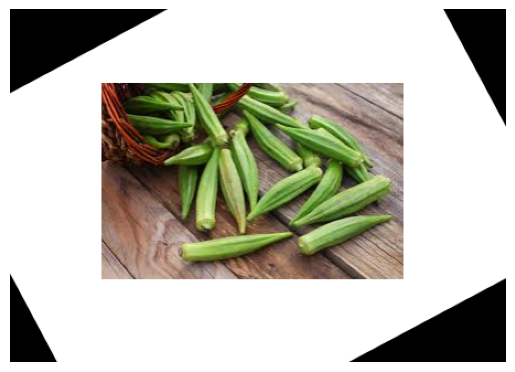

In [38]:
# Image path (Change this to your actual image path)
img_path = r"C:\Users\Welcome\ai\archive (1)\dataset\Test\freshokra\o_f040.png"

# Load image and resize to match model input
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = tf.keras.applications.resnet50.preprocess_input(img_array)  # Preprocessing

# Display the image
import matplotlib.pyplot as plt
plt.imshow(image.load_img(img_path))
plt.axis('off')
plt.show()


In [39]:
# Predict freshness category
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions)  # Get highest probability index
predicted_class_name = class_names[predicted_class_index]  # Map to class name

# Get the probability score of the predicted class
confidence_score = predictions[0][predicted_class_index] * 100  # Convert to percentage

# Print the predicted category with freshness score
print(f"Predicted Class: {predicted_class_name} ({confidence_score:.2f}% confidence)")


1/1 [==============================] - 0s 26ms/step
Predicted Class: freshokra (100.00% confidence)
